In [9]:
from pathlib import Path
from typing import Annotated

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import yaml
from pytask import Product

from caregiving.config import BLD
from caregiving.model.shared import FEMALE, MALE

In [38]:
def table(df_col):
    return pd.crosstab(df_col, columns="Count")["Count"]

def statsmodels_params_to_dict(params, name_prefix, name_constant=None):
    """Turn statsmodels regression params object into dict.

    Args:
        params (pd.Series): Pandas Series containing the parameter names and values.
        name_constant (str): A custom string to use in the new name for 'const'.
        name_prefix (str): A custom prefix to prepend to all parameter names.

    Returns:
        dict: A dictionary with regression parameters.

    """
    name_constant = "" if name_constant is None else name_constant + "_"

    return {
        f"{name_prefix}_{(f'{name_constant}constant' if key == 'const' else key)}": val
        for key, val in params.items()
    }


In [17]:
def run_binary_logit(df, outcome, parent):
    """
    Estimate binary logit for parent's survival (0 or 1).
    """
    formula = (
        f"{parent}_{outcome} ~ {parent}_age + I({parent}_age**2) + "
        f"C({parent}_lagged_health)"
    )
    model_parent = smf.logit(formula, data=df).fit()
    print(f"Results for {parent} (Binary Logit)")
    print(model_parent.summary())
    return model_parent

def plot_variable_distribution(df, column_name):
    """
    Plots the distribution of a categorical or binary variable in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to plot.
    """
    counts = df[column_name].value_counts(dropna=False).sort_index()

    plt.figure(figsize=(6, 4))
    counts.plot(kind='bar')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [11]:
path_to_raw_data = BLD / "data" / "estimation_data.csv"

path_to_save_parental_survival = (
    BLD / "estimation" / "stochastic_processes" / "parental_survival_params.csv"
)

In [16]:
df = pd.read_csv(path_to_raw_data)

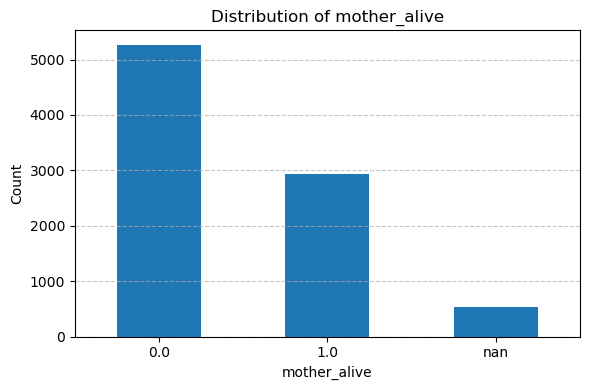

In [18]:
plot_variable_distribution(df, "mother_alive")

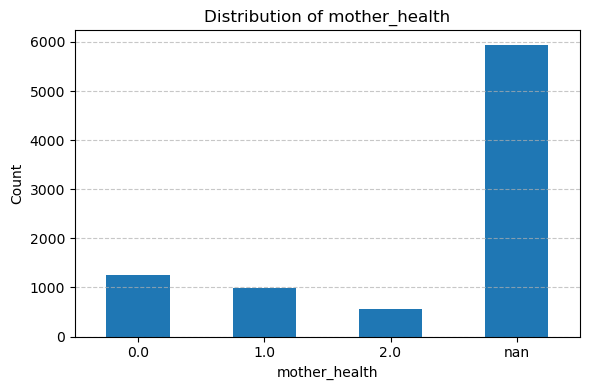

In [19]:
plot_variable_distribution(df, "mother_health")

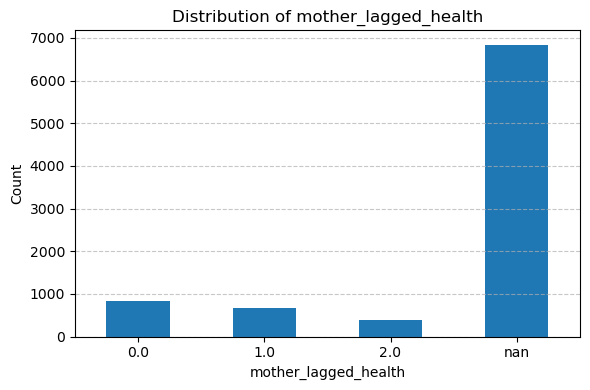

In [20]:
plot_variable_distribution(df, "mother_lagged_health")

In [23]:
table(df["mother_lagged_health"])

mother_lagged_health
0.0    844
1.0    676
2.0    379
Name: Count, dtype: int64

In [24]:
def _prepare_dependent_variables_health(data, health="health", age="age"):
    data = data.copy()

    data[f"father_{health}_good"] = np.where(
        data[f"father_{health}"] == 0,
        1,
        np.where(data[f"father_{health}"].isna(), np.nan, 0),
    )
    data[f"father_{health}_medium"] = np.where(
        data[f"father_{health}"] == 1,
        1,
        np.where(data[f"father_{health}"].isna(), np.nan, 0),
    )
    data[f"father_{health}_bad"] = np.where(
        data[f"father_{health}"] == 2,
        1,
        np.where(data[f"father_{health}"].isna(), np.nan, 0),
    )

    data[f"mother_{health}_good"] = np.where(
        data[f"mother_{health}"] == 1,
        1,
        np.where(data[f"mother_{health}"].isna(), np.nan, 0),
    )
    data[f"mother_{health}_medium"] = np.where(
        data[f"mother_{health}"] == 1,
        1,
        np.where(data[f"mother_{health}"].isna(), np.nan, 0),
    )
    data[f"mother_{health}_bad"] = np.where(
        data[f"mother_{health}"] == 2,
        1,
        np.where(data[f"mother_{health}"].isna(), np.nan, 0),
    )

    data[f"father_{age}_squared"] = data[f"father_{age}"] ** 2
    data[f"mother_{age}_squared"] = data[f"mother_{age}"] ** 2

    return data

In [28]:
dat = _prepare_dependent_variables_health(
    df,
    health="lagged_health",
    age="lagged_age",
)

In [35]:
x_mother_with_nans = sm.add_constant(
    dat[
        [
            "mother_lagged_age",
            "mother_lagged_age_squared",
            "mother_lagged_health_medium",
            "mother_lagged_health_bad",
        ]
    ],
)
x_mother = x_mother_with_nans.dropna()
data_mother = dat.dropna(
    subset=[
        "mother_lagged_age",
        "mother_lagged_age_squared",
        "mother_lagged_health_medium",
        "mother_lagged_health_bad",
    ],
)
x_female = x_mother[(data_mother["mother_alive"].notna())]
y_female = data_mother["mother_alive"][(data_mother["mother_alive"].notna())]
x_female = x_female.reset_index(drop=True)
y_female = y_female.reset_index(drop=True)

In [36]:
logit_female = sm.Logit(y_female, x_female).fit()

Optimization terminated successfully.
         Current function value: 0.350616
         Iterations 7


In [37]:
logit_female.params

const                         -18.635261
mother_lagged_age               0.641862
mother_lagged_age_squared      -0.004654
mother_lagged_health_medium    -0.492005
mother_lagged_health_bad       -1.608871
dtype: float64

In [40]:
params_mother = statsmodels_params_to_dict(
    logit_female.params,
    name_prefix="survival_prob",
    name_constant="mother",
)
params_mother

{'survival_prob_mother_constant': -18.635261219459725,
 'survival_prob_mother_lagged_age': 0.6418623035380162,
 'survival_prob_mother_lagged_age_squared': -0.0046541825825236385,
 'survival_prob_mother_lagged_health_medium': -0.49200470978549254,
 'survival_prob_mother_lagged_health_bad': -1.6088706724286093}

In [50]:
def compute_survival_prob(coefs, age, health_level):
    age_squared = age ** 2

    # One-hot encoding for health
    health_medium = 1 if health_level == 1 else 0
    health_bad = 1 if health_level == 2 else 0

    # logit = (
    #     coefs['intercept'] +
    #     coefs['age'] * age +
    #     coefs['age_squared'] * age_squared +
    #     coefs['health_medium'] * health_medium +
    #     coefs['health_bad'] * health_bad
    # )

    logit = (
        coefs["survival_prob_mother_constant"]
        + coefs["survival_prob_mother_lagged_age"] * age
        + coefs["survival_prob_mother_lagged_age_squared"] * age_squared
        + coefs["survival_prob_mother_lagged_health_medium"] * health_medium
        + coefs["survival_prob_mother_lagged_health_bad"] * health_bad
    )

    prob = 1 / (1 + np.exp(-logit))
    return prob

In [51]:
def plot_mother_survival_by_health(coefs, age_range=(60, 100)):
    """
    Plots the probability of mother being alive by age for three health levels (0: good, 1: medium, 2: bad).

    Parameters:
    - coefs (dict): Dictionary of logistic regression coefficients.
    - age_range (tuple): Range of ages to evaluate (inclusive).
    """
    
    # Prepare age range and labels
    ages = np.arange(age_range[0], age_range[1] + 1)
    health_labels = ['Good Health (0)', 'Medium Health (1)', 'Bad Health (2)']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    for i, health in enumerate([0, 1, 2]):
        probs = [compute_survival_prob(coefs, age, health) for age in ages]
        axes[i].plot(ages, probs)
        axes[i].set_title(f'Mother Survival Probability\n{health_labels[i]}')
        axes[i].set_xlabel('Age')
        axes[i].set_ylim(0, 1)
        axes[i].grid(True)

    axes[0].set_ylabel('Probability of Being Alive')
    plt.tight_layout()
    plt.show()

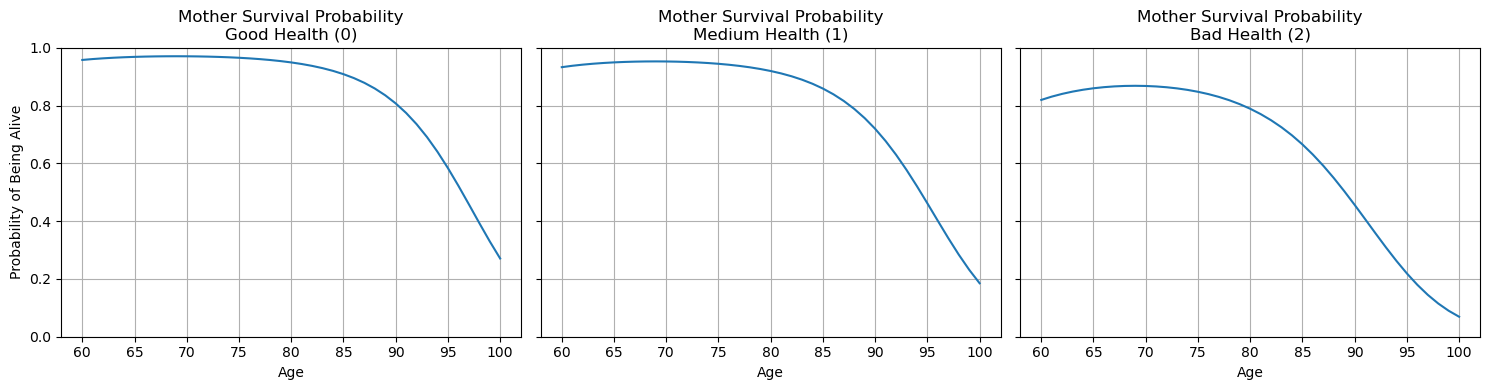

In [52]:
plot_mother_survival_by_health(params_mother)